---
## Table of Content
    # Load packages
    # Neural Network building
    # Function definitions
    # Load datasets (training and testing dataset)
    # Fine-tune model
        # KNN
        # Logistic
        # Random Forest
        # Neural Network (MLP)
    # Run experiment
        # Learning Curve
        # Confusion Matrix
        # Prediction Speed

---
# CIFAR-10 Final Report

---
# Packages

In [16]:
# load packages

# Classifiers: KNN, Logistic, RandomForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Classifier: Neural Network
import torch.nn as nn
import torch.nn.functional as F

# Finetuning
from sklearn.model_selection import cross_val_score
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Metric: Accuracy, Confusion Matrix, Prediction Speed
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import time

# Visualization
import matplotlib.pyplot as plt

# Data pre-processing
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve


# Data Acquisition
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

---
# Neural Network Building

In [17]:
class ConNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def fit(self, device, tr_loader, optimizer, criterion, epochs):
        self.train()

        for epoch in range(epochs):
            for X_tr, y_tr in tr_loader:
                X_tr, y_tr = X_tr.to(device), y_tr.to(device)
                optimizer.zero_grad()
                output = self(X_tr)
                loss = criterion(output, y_tr)
                loss.backward()
                optimizer.step()

    def test(self, device, te_loader):
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for X_te, y_te in te_loader:
                output = self(X_te)
                _, predicted = torch.max(output.data, 1)
                total += y_te.size(0)
                correct += (predicted == y_te).sum().item()
        return correct/total

---
# Function definitions

In [18]:
def convert_to_numpy(dataloader):
    data, labels = [], []
    for images, lbls in dataloader:
        data.append(images.view(images.size(0), -1).numpy())
        labels.append(lbls.numpy())
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels

def prepare_corpus(trainset:torchvision.datasets, testset:torchvision.datasets):
    """
    return standard scaled X and Y datasets
    """
    # select only part of the dataset (for efficiency)
    train_indices = list(range(10000)) 
    test_indices = list(range(2000))  
    # take subset
    train_subset = Subset(trainset, train_indices)
    test_subset = Subset(testset, test_indices)

    batch_size = 4
    subset_trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    subset_testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    # for loading full training and testing dataset
    # full_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    # full_testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    X_train, y_train = convert_to_numpy(subset_trainloader)
    X_test, y_test = convert_to_numpy(subset_testloader)

    # X_full_train, y_full_train = convert_to_numpy(full_trainloader)
    # X_full_test, y_full_test = convert_to_numpy(full_testloader)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # X_full_train = scaler.fit_transform(X_full_train)
    # X_full_test = scaler.transform(X_full_test)

    return X_train, y_train, X_test, y_test

In [19]:
def errors_for_train_sizes(clf, train_sizes, X_tr, y_tr, X_te, y_te):
    tr_err = [] 
    te_err = [] 

    for i in train_sizes:
        clf.fit(X_tr[:i], y_tr[:i])

        y_pred_tr = clf.predict(X_tr[:i])
        tr_err.append(1 - accuracy_score(y_tr[:i], y_pred_tr))

        y_pred_te = clf.predict(X_te)
        te_err.append(1 - accuracy_score(y_te, y_pred_te))

    return tr_err, te_err

def plot_errors_for_train_sizes(name:str, train_sizes, tr_err, te_err):
    plt.semilogx(train_sizes, tr_err, label='Train', marker='x', linestyle='-', color='blue')
    plt.semilogx(train_sizes, te_err, label='Test', marker='x', linestyle='--', color='blue')

    plt.xlabel('Number of Training Data Points')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.title(f'Error rate vs training data points for {name}')
    plt.show()

def reportLearningCurve(clf, name:str, train_sizes, X_train, y_train, X_test, y_test):
    tr_err, te_err = errors_for_train_sizes(clf, train_sizes, X_train, y_train, X_test, y_test)
    plot_errors_for_train_sizes(name, train_sizes, tr_err, te_err)

In [20]:
def reportConfusionMatrix(clf, name:str, X_test, y_test):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp:ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

In [21]:
def reportPredictionTime(clf, name:str, X_test):
    start_time = time.time()
    predictions = clf.predict(X_test)
    end_time = time.time()

    prediction_time = end_time - start_time
    time_per_image = prediction_time / len(X_test)
    print(f"Average prediction time per image by {name}: {time_per_image:.6f} seconds")

---
# Load datasets

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
                                        
X_train, y_train, X_test, y_test = prepare_corpus(full_trainset, full_testset)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


---
# Fine tune models

---
Fine tune KNN via 5 fold validation

In [23]:
k_values = [1, 5, 10, 50]
k_to_accuracies = {}

# 5-fold
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracies = cross_val_score(knn, X_train, y_train, cv=5)
    k_to_accuracies[k] = accuracies
    for accuracy in accuracies:
        print(f"k = {k}, accuracy = {accuracy:.4f}")

best_k = k_values[np.argmax([np.mean(v) for k, v in sorted(k_to_accuracies.items())])]
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

train_acc = accuracy_score(y_train, knn.predict(X_train))
test_acc = accuracy_score(y_test, knn.predict(X_test))

print(f"\nBest k: {best_k}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

k = 1, accuracy = 0.2780
k = 1, accuracy = 0.2730
k = 1, accuracy = 0.2700
k = 1, accuracy = 0.2890
k = 1, accuracy = 0.2990
k = 5, accuracy = 0.2920
k = 5, accuracy = 0.2690
k = 5, accuracy = 0.2890
k = 5, accuracy = 0.2980
k = 5, accuracy = 0.2890
k = 10, accuracy = 0.2935
k = 10, accuracy = 0.2755
k = 10, accuracy = 0.2925
k = 10, accuracy = 0.2960
k = 10, accuracy = 0.2825
k = 50, accuracy = 0.2900
k = 50, accuracy = 0.2630
k = 50, accuracy = 0.2775
k = 50, accuracy = 0.2750
k = 50, accuracy = 0.2790

Best k: 10, Train Accuracy: 0.3944, Test Accuracy: 0.2815


---
Fine tune Logistic via 5 fold validation

In [27]:
C_values = [0.01, 0.1, 1, 10, 100]
C_to_accuracies = {}

for C in C_values:
    lr = LogisticRegression(C=C, max_iter=5000, random_state=seed)
    accuracies = cross_val_score(lr, X_train, y_train, cv=5)
    C_to_accuracies[C] = accuracies
    for accuracy in accuracies:
        print(f"C = {C}, accuracy = {accuracy:.4f}")

best_C = C_values[np.argmax([np.mean(v) for C, v in sorted(C_to_accuracies.items())])]
lr = LogisticRegression(C=best_C, max_iter=5000, random_state=seed)
lr.fit(X_train, y_train)

train_acc = accuracy_score(y_train, lr.predict(X_train))
test_acc = accuracy_score(y_test, lr.predict(X_test))

print(f"\nBest C: {best_C}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

KeyboardInterrupt: 

---
Fine tune RandomForest via grid search

In [ ]:
parameters = {
    "n_estimators" : [5,25,50,100],
    "min_samples_split" : [2,5,10],
    "min_samples_leaf" : [2,5,10]
}
record = dict()
for x in parameters["n_estimators"]:
    for y in parameters["min_samples_split"]:
        for z in parameters["min_samples_leaf"]:
            print(x,y,z, sep="      ")
            clf:RandomForestClassifier = RandomForestClassifier(n_estimators=x,
                                                    criterion = 'gini',
                                                    min_samples_split = y,
                                                    min_samples_leaf = z,
                                                    )
            clf.fit(X_train, y_train)
            acc = accuracy_score(y_test, clf.predict(X_test))
            record[acc] = record.get(acc, []) +[(x,y,z)]
            print("Accuracy: ", acc)

best_acc = max(record.keys())
best_model = record[best_acc]

print("Best model (hyper parameters): ", best_model, "Accuracy_score: ", best_acc )

---
Fine tune neural network via Scheduler

In [28]:
model = ConNeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.fit(device, tr_loader, optimizer, criterion, epochs=10)

print('Finished Training')

print(model.test(device, te_loader))

NameError: name 'tr_loader' is not defined

---
# Performance Report

In [29]:
best_k = 10
best_C = 0.01

# set up fine tuned models
knn = KNeighborsClassifier(n_neighbors=best_k)
lr = LogisticRegression(C=best_C, max_iter=5000, random_state=seed)
rf = RandomForestClassifier(n_estimators=100, criterion = 'gini', min_samples_split = 5, min_samples_leaf = 5)
#neural = model

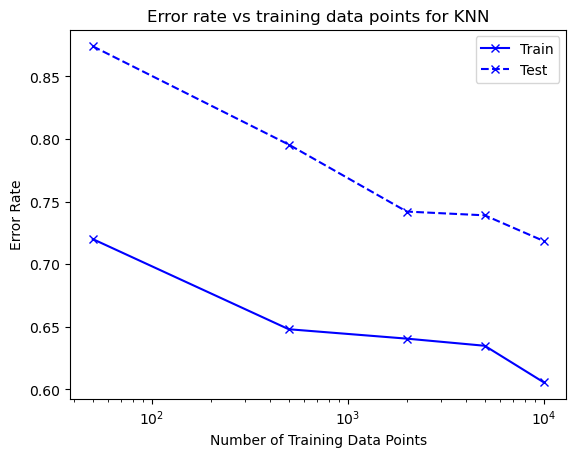

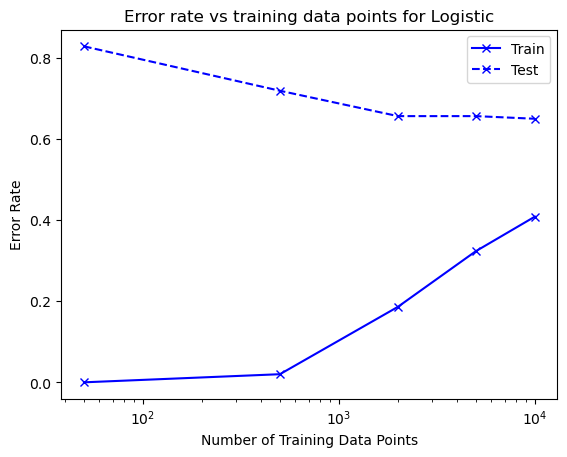

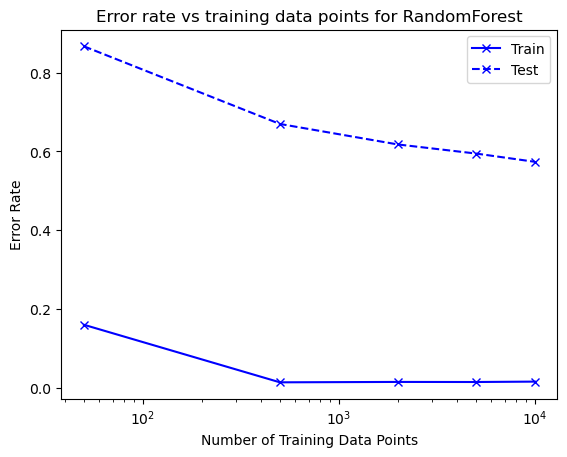

In [31]:
# report Learning curve
train_sizes = [50, 500, 2000, 5000, 10000]
reportLearningCurve(knn, "KNN", train_sizes, X_train, y_train, X_test, y_test)
reportLearningCurve(lr, "Logistic", train_sizes, X_train, y_train, X_test, y_test)
reportLearningCurve(rf, "RandomForest", train_sizes, X_train, y_train, X_test, y_test)

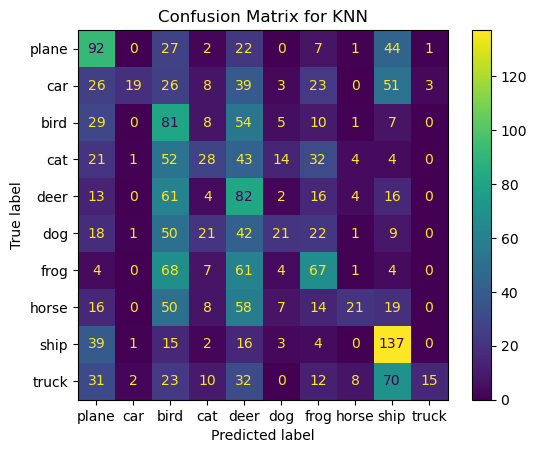

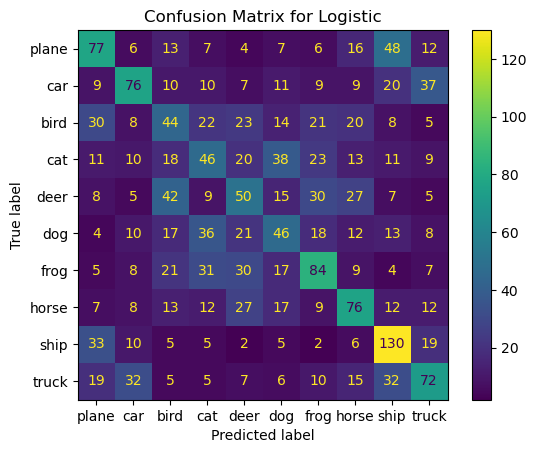

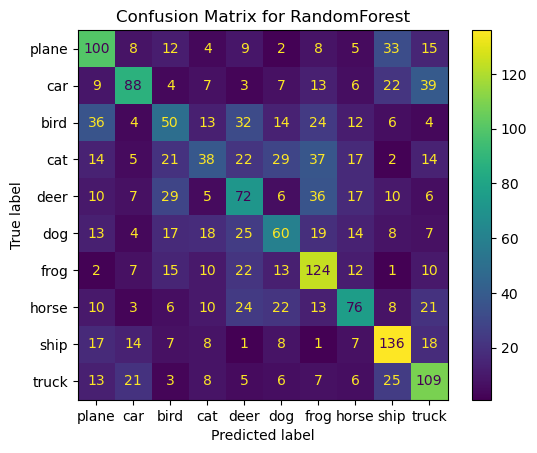

In [32]:
# report Confusion matrix
reportConfusionMatrix(knn, "KNN", X_test=X_test, y_test = y_test)
reportConfusionMatrix(lr, "Logistic", X_test=X_test, y_test = y_test)
reportConfusionMatrix(rf, "RandomForest", X_test=X_test, y_test = y_test)

In [33]:
# report Prediction speed
reportPredictionTime(knn, name = "KNN", X_test=X_test)
reportPredictionTime(lr, name = "Logistic", X_test=X_test)
reportPredictionTime(rf, name = "RandomForest", X_test=X_test)

Average prediction time per image by KNN: 0.001156 seconds
Average prediction time per image by Logistic: 0.000018 seconds
Average prediction time per image by RandomForest: 0.000043 seconds
